# Image Processing with Python: Applications in Machine Learning


### How can image processing techniques be used to prepare data for a machine learning algorithm?

In this post, we will learn the step-by-step procedures on how to preprocess and prepare image datasets to extract quantifiable features that can be used for a machine learning algorithm.

Let’s begin.

As usual, we import libraries such as `numpy`, `pandas`, and `matplotlib`. Additionally, we import specific functions from the `skimage` and `sklearn` library.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.morphology import area_closing, area_opening
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Our objective is to extract information from each sample that can be used for our machine learning algorithm. Let’s tackle this step-by-step!

### STEP 1: Perform Exploratory Data Analysis (EDA)

EDA is always an essential part when building a machine learning algorithm. First and foremost, you should be able to familiarize yourself with the data — its structure, its formatting, and its nuances. This is crucial to ensure that the project methodology that you will conceptualize will be appropriate for the dataset at hand.

For this project, the dataset that we will be using is a collection of dried plant leaves specimens in a white background. There are three classes of plant leaves in this dataset — such as plantA, plantB, and plantC.

In [ ]:
filepaths = glob('dataset/*.jpg')
print("The shape of the image is:", imread(filepaths[0]).shape)

The shape of the image is: (876, 637, 3)


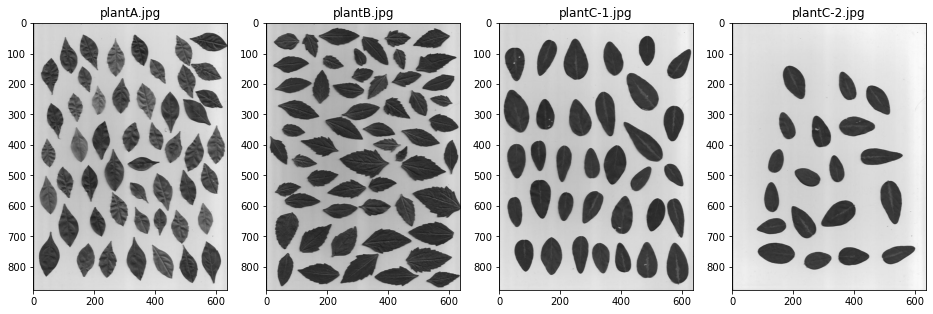

In [ ]:
fig, axis = plt.subplots(1,len(filepaths), figsize=(16,8))

for x, ax in zip(filepaths, axis.flatten()):
    ax.imshow(imread(x))
    ax.set_title(x.split('\\')[1])

Notice that each of the class of leaves have a distinct characteristic on it. PlantA can be characterized by the cirration on its leaf body, PlantB can be characterized by its leaves’ rugged edges, and PlantC can be characterized by its leaves’ rounded shape.

Moreover, notice that even though the data is in grayscale, the images still contain three channels. However, further inspecting, we can notice that the three channels are mere duplicates of each other. Because of this, we can drop the other channels by slicing the array or by using the `rgb2gray` function.

### STEP 2: Image Binarization

From the EDA findings, we can now utilize the `rgb2gray` function to convert the image’s three channels into a single channel. After which, we can perform image thresholding to extract the necessary information in the images — in this case, the leaves. Since the image dataset is a classic example of a background-foreground image, we can utilize Otsu’s Method to threshold the image.

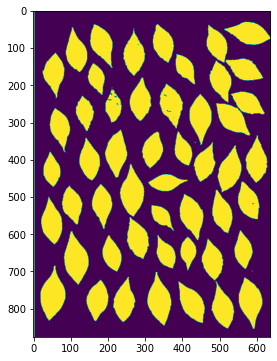

In [ ]:
leaf = imread(filepaths[0])
gray_leaf = rgb2gray(leaf)

thresh = threshold_otsu(gray_leaf)
binarized = gray_leaf < thresh

plt.figure(figsize=(6,6))
plt.imshow(binarized);

### STEP 3: Apply Morphological Operations

Now, you might ask, why do we need to apply morphological operations if the image appears to be clean? It is a good practice to still perform morphological operations to remove the noise in the image — especially in images with a large number of pixels. Remember that a single pixel noise might not be visible to the naked eye, but it can later affect your image analysis!

To minimize the distortion of the objects’ shapes, we will use the `area_closing` and `area_opening` morphological operations. We apply the `area_closing` function to fill in any holes inside the region of the object of interest. In this dataset, `area_closing` can be particularly useful if the leaf regions have damages, cirration, or fibers that have a different pixel intensity than the leaf body. After which, we have applied the `area_opening` function to remove noise in the image background.


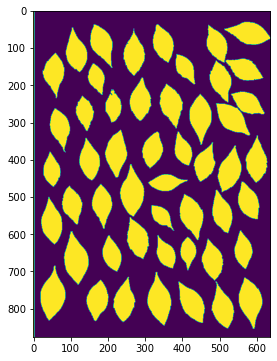

In [ ]:
closed = area_closing(binarized)
opened = area_opening(closed)
plt.figure(figsize=(6,6))
plt.imshow(opened)

### STEP 4: Label each region using Connected Components

After cleaning the dataset, we will utilize the connected components’ `label` function to identify all regions of the image. Then, we can use the `regionprops` function to extract properties from each region in the image.

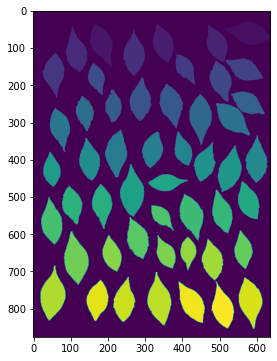

In [ ]:
label_im = label(opened)
regions = regionprops(label_im)
plt.figure(figsize=(6,6))
plt.imshow(label_im)

Notice how each region has a varying color. Each color represents a region in the image. The numbering of these regions’ grouping is from left to right, then from top to bottom. Moreover, we should remember that the zeroth region in the resulting array of the label function is always the image’s background. Finally, in filtering the regions, we will use an if-else statement. The two conditions in the if-else statement are: the background region and the regions with the negligible area are not included.

Now, let’s try to look at these regions individually!

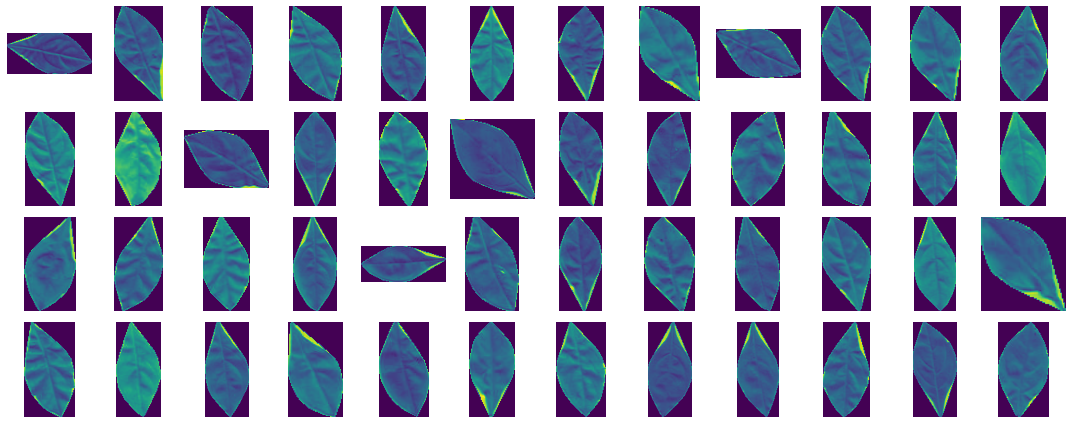

In [ ]:
masks = []
bbox = []
for num, x in enumerate(regions):
    area = x.area
    convex_area = x.convex_area
    if num!=0 and x.area >= 100:
        masks.append(regions[num].convex_image)
        bbox.append(regions[num].bbox)
count = len(masks)

fig, axis = plt.subplots(4, int(count/4), figsize=(15,6))

for ax, box, mask in zip(axis.flatten(), bbox, masks):
    image  =  gray_leaf[box[0]:box[2], box[1]:box[3]] * mask
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()

### STEP 5: Get the properties of each region

Now, visualizing the regions can be very useful to counter-check if the image processing steps are effective. However, our objective is to extract key features and properties from each of these regions! We can easily do this using the `regionprops_table` function, wherein we can specify the properties extracted from the regions. In this dataset, we will be using the following quantifiable properties:

1. `area` — Number of pixels of the region.
2. `convex_area` — Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.
3. `bbox_area` — Number of pixels of bounding box.
4. `major_axis_length` — The length of the ellipse’s major axis has the same normalized second central moments as the region.
5. `minor_axis_length` — The length of the ellipse’s minor axis has the same normalized second central moments as the region.
6. `perimeter` — Perimeter of object which approximates the contour as a line through the centers of border pixels using a 4-connectivity.
7. `equivalent_diameter` — The diameter of a circle with the same area as the region.
8. `mean_intensity` -Value with the mean intensity in the region.
9. `solidity` — Ratio of pixels in the region to pixels of the convex hull image.
10. `eccentricity` — Eccentricity of the ellipse that has the same second-moments as the region

In [ ]:
properties = ['area','convex_area','bbox_area','major_axis_length',
              'minor_axis_length', 'perimeter', 'equivalent_diameter',
              'mean_intensity', 'solidity', 'eccentricity']
pd.DataFrame(regionprops_table(label_im, gray_leaf, properties=properties)).head(10)

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity
0,3504,3504,3504,1011.517013,4.472136,1756.000000,66.793947,0.185244,1.000000,0.999990
1,4675,4912,7625,108.498126,56.367825,303.563492,77.151765,0.231123,0.951751,0.854453
2,4220,4493,7020,105.230307,53.067724,297.078210,73.301234,0.273463,0.939239,0.863528
3,3774,3896,5768,94.849351,51.403214,258.936075,69.319593,0.232451,0.968686,0.840413
4,3551,3724,5656,93.200861,49.628386,263.279221,67.240417,0.347455,0.953545,0.846437
5,4165,4394,6840,103.895309,52.941859,291.249783,72.821993,0.267084,0.947883,0.860430
6,4275,4636,7308,103.935866,53.544588,308.699531,73.777361,0.385603,0.922131,0.857088
7,4003,4331,7018,100.118175,53.164396,291.942172,71.391721,0.253669,0.924267,0.847362
8,2549,2693,4212,80.943459,41.405059,222.166522,56.969181,0.335107,0.946528,0.859265
9,3758,3964,5959,94.730161,51.926653,273.693434,69.172496,0.288830,0.948032,0.836378


### STEP 6: Combine All the Steps into a Single Function

Now that we have established the steps and checked that the data extracted is good, we can now automate all previous steps into a single function. This is particularly useful to extract the features needed in the machine learning algorithm quickly.

In [ ]:
def get_properties(name):
    filepaths = glob('dataset/{}*.jpg'.format(name))
    properties = ['area','convex_area','bbox_area','major_axis_length',
                  'minor_axis_length', 'perimeter', 'equivalent_diameter',
                  'mean_intensity', 'solidity', 'eccentricity']
    dataframe = pd.DataFrame(columns=properties)
    for file in filepaths:
        grayscale = rgb2gray(imread(file))
        threshold = threshold_otsu(grayscale)
        binarized = grayscale < threshold
        closed = area_closing(binarized, 1000)
        opened = area_opening(closed, 1000)
        labeled = label(opened)
        regions = regionprops(labeled)
        data = pd.DataFrame(regionprops_table(labeled, grayscale,
                                              properties=properties))
        data = data[(data.index!=0) & (data.area>100)]
        dataframe = pd.concat([dataframe, data])
    return dataframe

### STEP 7: Collect Features Dataframe

Using the `get_properties` function created, we can now collect each region’s features and properties in the image! Once the properties are collected, don’t forget to input the label classification of these properties — this will serve as the ground truth for the machine learning algorithm.

Let’s extract the dataframe for plantA.

In [ ]:
plantA = get_properties('plantA')
plantA['type'] = 'plantA'
print("The shape of the dataframe is: ", plantA.shape)
plantA.head()

The shape of the dataframe is:  (50, 11)


,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity,type
1,4675,4912,7625,108.498126,56.367825,303.563492,77.151765,0.231123,0.951751,0.854453,plantA
2,4220,4493,7020,105.230307,53.067724,297.078210,73.301234,0.273463,0.939239,0.863528,plantA
3,3774,3896,5768,94.849351,51.403214,258.936075,69.319593,0.232451,0.968686,0.840413,plantA
4,3551,3724,5656,93.200861,49.628386,263.279221,67.240417,0.347455,0.953545,0.846437,plantA
5,4165,4394,6840,103.895309,52.941859,291.249783,72.821993,0.267084,0.947883,0.860430,plantA


Now, for plantB.

In [ ]:
plantB = get_properties('plantB')
plantB['type'] = 'plantB'
print("The shape of the dataframe is: ", plantB.shape)
plantB.head()

The shape of the dataframe is:  (55, 11)


,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity,type
1,4714,4922,7714,117.858605,51.951857,314.977705,77.472906,0.200711,0.957741,0.897606,plantB
2,4535,4794,7920,107.372708,55.675484,310.634560,75.987771,0.201414,0.945974,0.855062,plantB
3,2926,3219,4760,76.789674,50.087136,245.036580,61.036865,0.226798,0.908978,0.757992,plantB
4,3071,3164,4565,76.111242,51.993223,220.693434,62.530941,0.250061,0.970607,0.730305,plantB
5,2574,2821,4212,74.932355,45.275098,225.758405,57.247870,0.232253,0.912442,0.796823,plantB


Lastly, for plantC.

In [ ]:
plantC = get_properties('plantC')
plantC['type'] = 'plantC'
print("The shape of the dataframe is: ", plantC.shape)
plantC.head()

The shape of the dataframe is:  (53, 11)


,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity,type
1,3945,4009,5247,96.229114,52.480517,252.793939,70.872632,0.202611,0.984036,0.838195,plantC
2,7712,7826,10935,130.351864,76.981552,355.948268,99.091994,0.215861,0.985433,0.806988,plantC
3,5004,5083,7670,121.941483,53.008663,302.249783,79.820365,0.217994,0.984458,0.900573,plantC
4,5216,5294,7392,110.950586,60.207864,289.320851,81.493665,0.223887,0.985266,0.839956,plantC
5,5208,5303,7150,109.018096,62.245090,294.007143,81.431146,0.220773,0.982086,0.820977,plantC


Now that we have collected the properties of each object in the dataset, let us combine these information in a single dataframe!

In [ ]:
df = pd.concat([plantA, plantB, plantC])
df

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity,type
1,4675,4912,7625,108.498126,56.367825,303.563492,77.151765,0.231123,0.951751,0.854453,plantA
2,4220,4493,7020,105.230307,53.067724,297.078210,73.301234,0.273463,0.939239,0.863528,plantA
3,3774,3896,5768,94.849351,51.403214,258.936075,69.319593,0.232451,0.968686,0.840413,plantA
4,3551,3724,5656,93.200861,49.628386,263.279221,67.240417,0.347455,0.953545,0.846437,plantA
5,4165,4394,6840,103.895309,52.941859,291.249783,72.821993,0.267084,0.947883,0.860430,plantA
...,...,...,...,...,...,...,...,...,...,...,...
15,3619,3685,5088,93.300191,50.049722,244.793939,67.881175,0.227478,0.982090,0.843940,plantC
16,6337,6420,8470,119.856064,67.478982,317.078210,89.824935,0.218282,0.987072,0.826457,plantC
17,4345,4413,6588,111.896530,50.538035,278.936075,74.378934,0.243527,0.984591,0.892195,plantC
18,4469,4540,6060,99.248680,58.286507,267.036580,75.432801,0.213214,0.984361,0.809386,plantC


### STEP 8: Apply Feature Engineering

From the extracted features, we can further expand the features by deriving new features. This can easily be done by getting the ratios of the extracted features together. Let’s try this!

In [ ]:
df['ratio_length'] = df['major_axis_length'] / df['minor_axis_length']
df['perimeter_ratio_major'] = df['perimeter'] / df['major_axis_length']
df['perimeter_ratio_minor'] = df['perimeter'] / df['minor_axis_length']
df['area_ratio_convex'] = df['area'] / df['convex_area']
df['area_ratio_bbox'] = df['area'] / df['bbox_area']
df['peri_over_dia'] = df['perimeter'] / df['equivalent_diameter']

final_df = df[df.drop('type', axis=1).columns].astype(float)
final_df = final_df.replace(np.inf, 0)
final_df['type'] = df['type']
final_df

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity,ratio_length,perimeter_ratio_major,perimeter_ratio_minor,area_ratio_convex,area_ratio_bbox,peri_over_dia,type
1,4675.0,4912.0,7625.0,108.498126,56.367825,303.563492,77.151765,0.231123,0.951751,0.854453,1.924824,2.797869,5.385404,0.951751,0.613115,3.934628,plantA
2,4220.0,4493.0,7020.0,105.230307,53.067724,297.078210,73.301234,0.273463,0.939239,0.863528,1.982944,2.823124,5.598096,0.939239,0.601140,4.052841,plantA
3,3774.0,3896.0,5768.0,94.849351,51.403214,258.936075,69.319593,0.232451,0.968686,0.840413,1.845203,2.729972,5.037352,0.968686,0.654300,3.735395,plantA
4,3551.0,3724.0,5656.0,93.200861,49.628386,263.279221,67.240417,0.347455,0.953545,0.846437,1.877975,2.824858,5.305013,0.953545,0.627829,3.915491,plantA
5,4165.0,4394.0,6840.0,103.895309,52.941859,291.249783,72.821993,0.267084,0.947883,0.860430,1.962442,2.803301,5.501314,0.947883,0.608918,3.999476,plantA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,3619.0,3685.0,5088.0,93.300191,50.049722,244.793939,67.881175,0.227478,0.982090,0.843940,1.864150,2.623724,4.891015,0.982090,0.711281,3.606212,plantC
16,6337.0,6420.0,8470.0,119.856064,67.478982,317.078210,89.824935,0.218282,0.987072,0.826457,1.776198,2.645492,4.698918,0.987072,0.748170,3.529958,plantC
17,4345.0,4413.0,6588.0,111.896530,50.538035,278.936075,74.378934,0.243527,0.984591,0.892195,2.214105,2.492804,5.519330,0.984591,0.659532,3.750203,plantC
18,4469.0,4540.0,6060.0,99.248680,58.286507,267.036580,75.432801,0.213214,0.984361,0.809386,1.702773,2.690581,4.581448,0.984361,0.737459,3.540059,plantC


By doing so, we were able to expand our dataframe to 17 features!

### STEP 9: Split the Training and Test Set

The next step is to split the data from the dataframe of the extracted and derived features on the image data. This is critical to ensure that the machine learning model will have a set of “unseen” data to ensure that the training is not overfitting or underfitting. We do this using the `train_test_split` function in the `sklearn.model_selection` library. Moreover, we will also not do any data imbalance handling techniques because the number of instances per class is approximately equal to each other.

In [ ]:
X = final_df.drop('type', axis=1)
y = final_df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify = y,
                                                    random_state=1337)


### STEP 10: Train a Random Forest Classifier Model

Using the training dataset, we can now train a machine learning classifier model. We will be using a Random Forest Classifier because it is known to yield a high level of accuracy despite the simplicity of its algorithm. Note that since the Random Forest model is a tree-based model, we do not need to scale the dataset. However, if you will be using other machine learning models, you must scale the features of the dataset.

In [ ]:
RF = RandomForestClassifier(max_depth=7, n_estimators=100)
RF.fit(X_train, y_train)
y_pred_RF= RF.predict(X_test)

df = pd.DataFrame()

cols = ['Machine Learning Classification Method',
        'Train Accuracy',
        'Test Accuracy',
        "Top 1 Feature Predictor",
        "Top 2 Feature Predictor",
        "Top 3 Feature Predictor",
        "Top 4 Feature Predictor",
        "Top 5 Feature Predictor"]

df.loc['Machine Learning Classification Method',
       'Details'] = 'Random Forest Classifier'
df.loc['Train Accuracy', 'Details'] = RF.score(X_train, y_train)
df.loc['Test Accuracy', 'Details'] = RF.score(X_test, y_test)

feature_importances = X.columns[np.argsort(RF.feature_importances_)][-5:]
df.loc['Top 1 Feature Predictor', 'Details'] = feature_importances[4]
df.loc['Top 2 Feature Predictor', 'Details'] = feature_importances[3]
df.loc['Top 3 Feature Predictor', 'Details'] = feature_importances[2]
df.loc['Top 4 Feature Predictor', 'Details'] = feature_importances[1]
df.loc['Top 5 Feature Predictor', 'Details'] = feature_importances[0]

display(df)

,Details
Machine Learning Classification Method,Random Forest Classifier
Train Accuracy,1
Test Accuracy,0.9
Top 1 Feature Predictor,mean_intensity
Top 2 Feature Predictor,area_ratio_convex
Top 3 Feature Predictor,solidity
Top 4 Feature Predictor,perimeter_ratio_major
Top 5 Feature Predictor,peri_over_dia


The Random Forest Classifier yielded a test accuracy of 90.00%. The top features in classifying the different leaves are their `mean_intensity`, `area_ratio_convex`, `solidity`, `perimeter_ratio_major`, and `peri_over_dia`.

Going back to our initial findings in the EDA, we can relate why the mean_intensity is the top 1 predictor is because we have previously identified that plantA can be identified by the cirration in its leaves. Cirration can easily be reflected in the pixel intensity of the objects.

Moreover, the ratio between the area and convex area is the top 2 predictor is because we have identified that plantB to have rugged edges while plantC to have rounded edges. Therefore, plantB will naturally have a lower number, while plantC will have an `area_ratio_convex` that is approximately equal to 1.

Awesome, right? A model that is **both accurate and interpretable**! With this, I hope you were able to appreciate the importance of image processing techniques to achieve a more interpretable machine learning algorithm!

#### In summary

We have explored how to use image processing techniques to prepare and preprocess image datasets to implement a machine learning algorithm. Using the `regionprops_table` function, we were able to extract valuable and quantifiable features from the image. In the end, we have developed a classifier model that achieved a high accuracy while also being interpretable.


